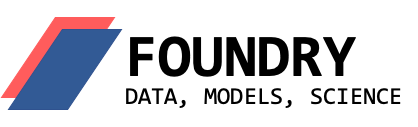

# Foundry Dendrite Segmentation Tutorial for Beginners
This introduction uses Foundry to:


1.   Load data from Foundry
2.   Build a predictuve U-Net model
3. Create augmented data to use with the model

This notebook is set up to run as a [Google Colaboratory](https://colab.research.google.com/notebooks/intro.ipynb#scrollTo=5fCEDCU_qrC0) notebook, which allows you to run python code in the browser, or as a [Jupyter](https://jupyter.org/) notebook, which runs locally on your machine.

The code in the next cell will detect your environment to make sure that only cells that match your environment will run.


In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Installing Foundry
First we'll need to install Foundry and [MDF](https://materialsdatafacility.org/). If you're running the notebook locally, just make sure that Foundry and MDF are installed in your local environment. We'll also need [keras-unet](https://pypi.org/project/keras-unet/) for our UNet model.

If you're using Google Colab, run the code below to install.

*Due to a recent FuncX update, we need to use FuncX 0.0.5 (FuncX is included in the Foundry install). This install is a temporary fix that makes sure we have the version we need.

In [ ]:
if IN_COLAB:
  !pip install foundry_ml
  !pip install mdf_connect_client
  !pip install funcx==0.0.5
  !pip install keras-unet

# Importing Packages
Now we can import Foundry, which will allow us to load the data. 

We'll be using [scikit-image](https://scikit-image.org/) for image processing; [Keras](https://keras.io/) and [TensorFlow](https://www.tensorflow.org/) to create our model; and [pandas](https://pandas.pydata.org/), [OpenCV](https://pypi.org/project/opencv-python/), and [NumPy ](https://numpy.org/)to work with our data.

In [ ]:
from foundry import Foundry
from skimage.io import imshow, imread
from keras_unet.models import custom_unet
import matplotlib.pyplot as plt
from keras_unet.utils import plot_imgs
import numpy as np
import cv2
import numpy as np
import tensorflow as tf
from keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance
from keras_unet.utils import get_augmented

# Instantiating Foundry
To instantiate Foundry, you'll need a [Globus](https://www.globus.org) account. Once you have your account, you can instantiate Foundry using the code below. When you instantiate Foundry locally, be sure to have your Globus endpoint turned on (you can do that with [Globus Connect Personal](https://www.globus.org/globus-connect-personal)). When you instantiate Foundry on Google Colab, you'll be given a link in the cell's output and asked to enter the provided auth code.


In [ ]:
if IN_COLAB:
  f = Foundry(no_local_server=True, no_browser=True) #instantiating in colab
else:
  f = Foundry() #instantiating locally

# Loading the Data
Now we can use our instance of Foundry to load the data using `f.load()`. Once the data is loaded and accessible, we load the data into the client using `f.load_data()`.

In [9]:
if IN_COLAB:
  f = f.load("_test_foundry_stan_dendrite_segmentation_v1.1", globus=False)
else:
  f = f.load("_test_foundry_stan_dendrite_segmentation_v1.1")

Done curling.
[{'/foundry/_test_foundry_stan_dendrite_segmentation_v1.1/foundry.hdf5 status': True}]


In [10]:
X,y = f.load_data()
X,y = X[0], y[0]

# Visualizing the Data

Now that we've loaded the data, let's take a look!

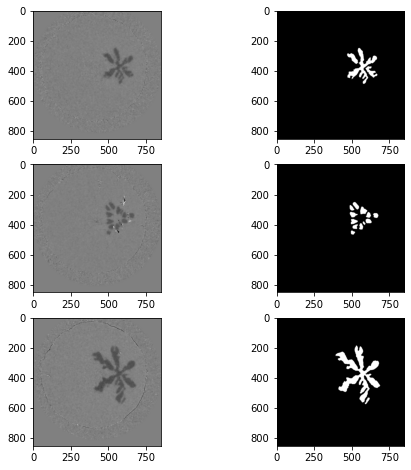

In [11]:
fig, axs = plt.subplots(3,2, figsize=(8,8))
for i in range(3):
    axs[i][0].imshow(X[i])
    axs[i][1].imshow(y[i])

# Building a Model
## Resize to Match UNet
UNet requires images to be of a size multiple of 32

In [12]:
new_size = 32*10 # U-Net requires a multiple of 32

X_r = np.array([cv2.resize(img, dsize=(new_size, new_size)) 
     for img in X])
y_r = np.array([cv2.resize(mask, dsize=(new_size, new_size)) 
     for mask in y])

In [13]:
y_r.shape

(30, 320, 320, 3)

## Create UNet Model

In [14]:
input_shape = (new_size,new_size,3)

model = custom_unet(input_shape)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 320, 320, 16) 432         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 320, 320, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 320, 320, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Preview the Segmentation Task

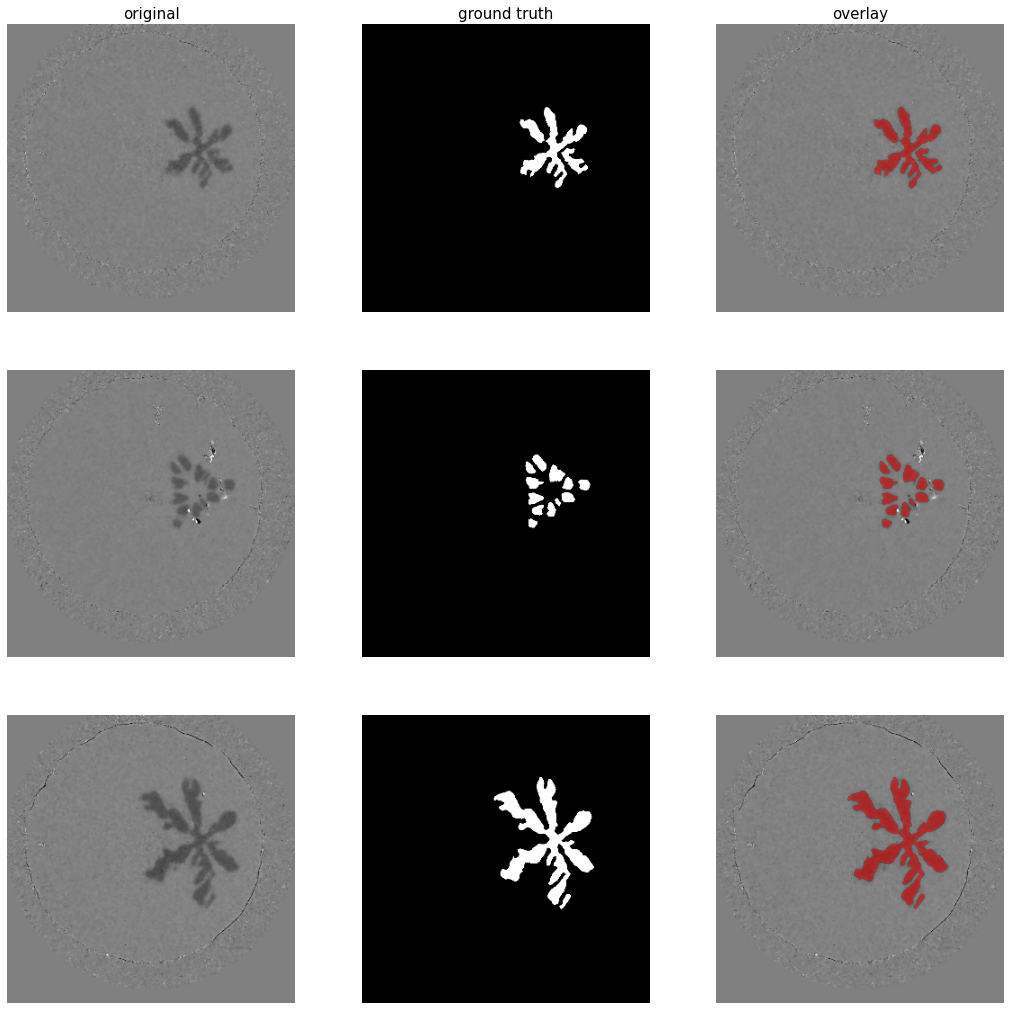

In [16]:
plot_imgs(org_imgs=X_r, mask_imgs=y_r[:,:,:,0], nm_img_to_plot=3, figsize=6)


# Create a Generator with Augmented Images

In [17]:
X_r.shape

(30, 320, 320, 3)

In [18]:
y_r.shape

(30, 320, 320, 3)

In [19]:
n_images = 30
y_c = y_r[:,:,:,0]

train_gen = get_augmented(
    X_r, np.reshape(y_c, (n_images, new_size, new_size, 1)), batch_size=2,
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=30,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

# Preview Augmented Images

(2, 320, 320, 3) (2, 320, 320, 1)


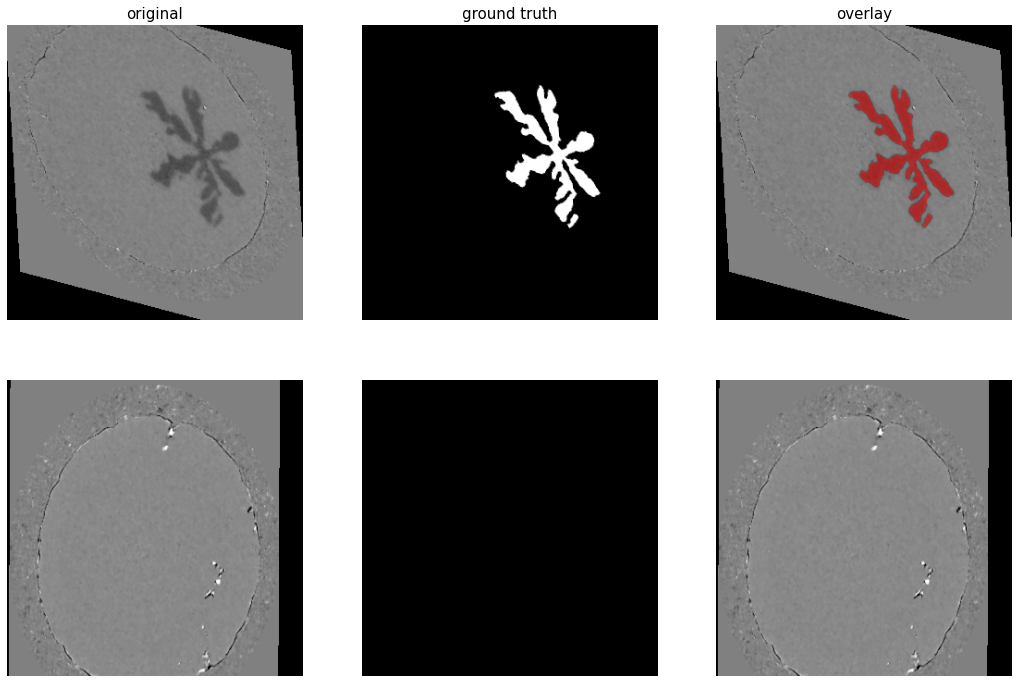

In [20]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy[:,:,:,0], nm_img_to_plot=2, figsize=6)

# Compile Model

In [21]:
model.compile(
    optimizer="adam", 
    #optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[tf.keras.metrics.MeanIoU(num_classes=2)]
)

# Fit Model

In [ ]:
history = model.fit(
train_gen,
    steps_per_epoch=200,
    epochs=10
)

In [ ]:
model.save(f"./{new_size}x{new_size}-model.h5") 

In [ ]:
model = tf.keras.models.load_model('./model_checkpoint.h5')

# Run Predict on Images

In [ ]:
y_pred = model.predict(X_r)

# Check Performance Visually

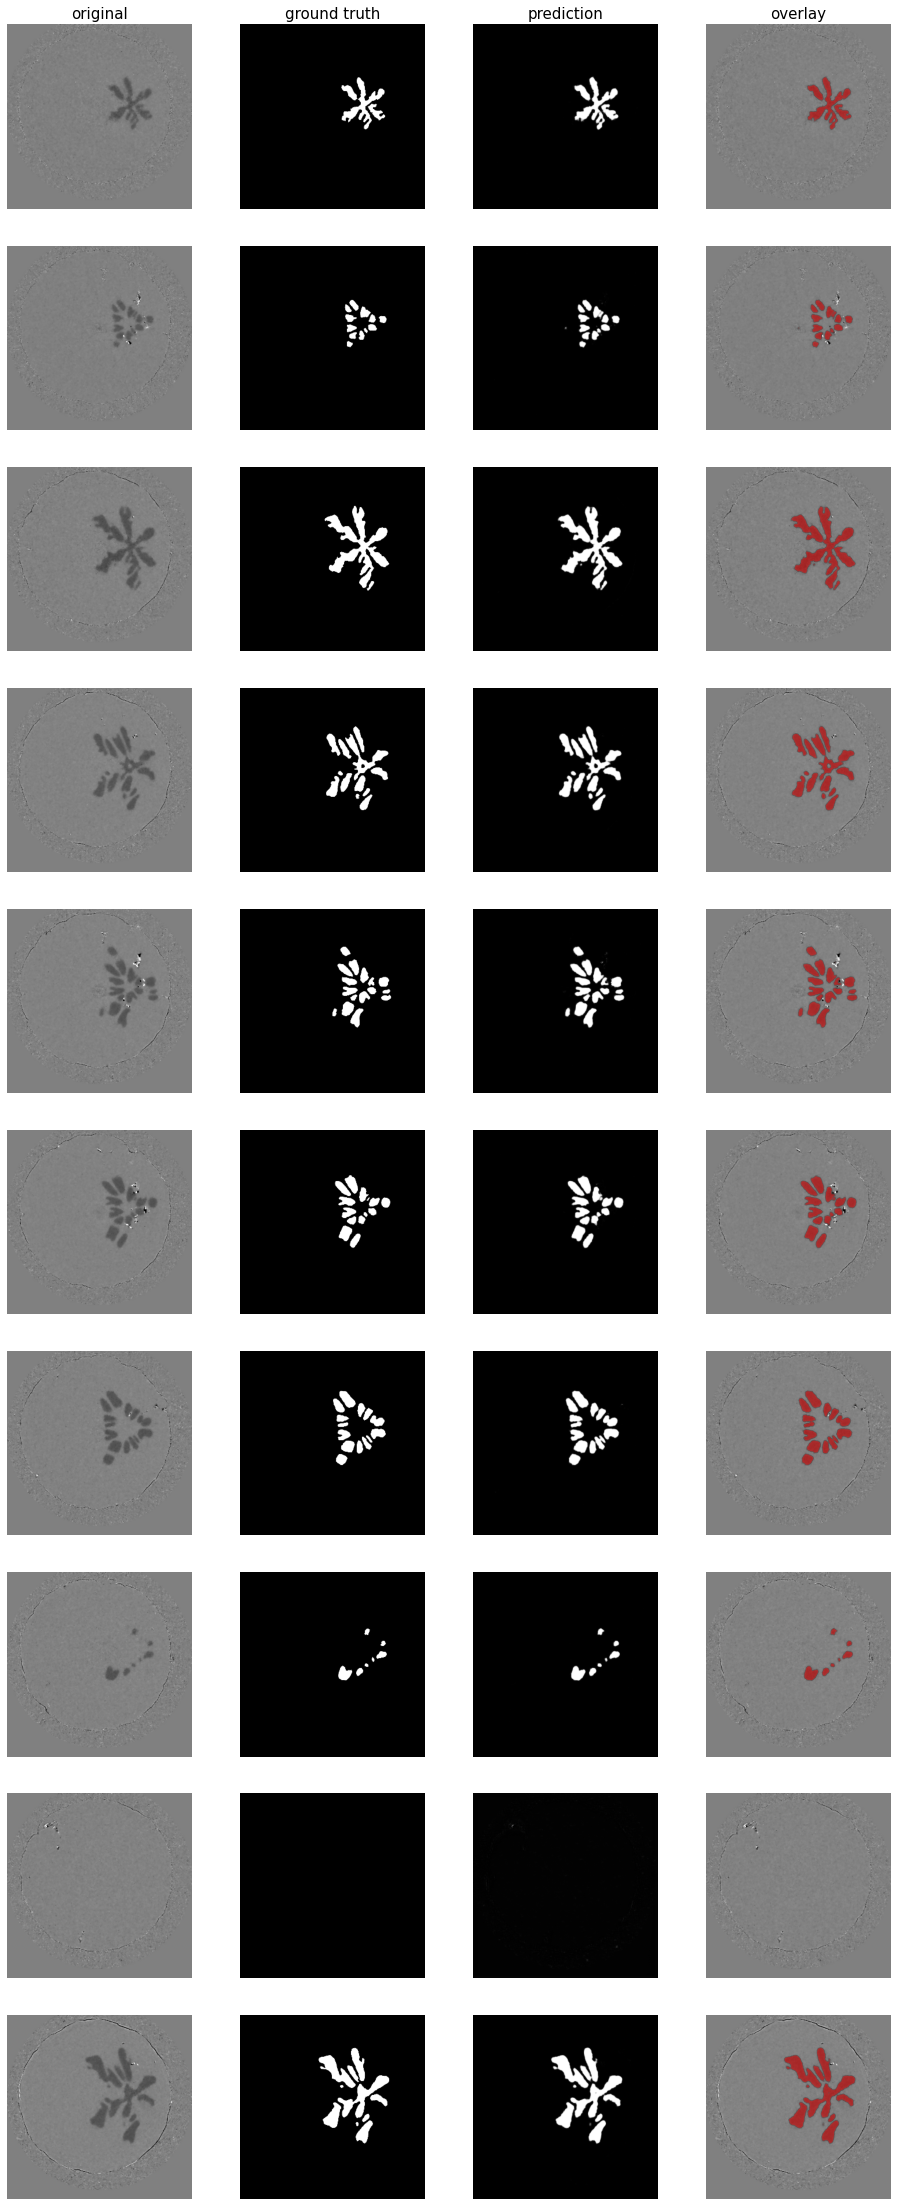

In [ ]:
plot_imgs(org_imgs=X_r, mask_imgs=y_c, pred_imgs=y_pred, nm_img_to_plot=10)

# Create Metadata

In [2]:
metadata = {
    "dc": {
        'creators': [
            {'creatorName': 'Stan, Tiberiu',
             'familyName': 'Stan',
             'givenName': 'Tiberiu'},
            {'creatorName': 'Thompson, Zach',
             'familyName': 'Thompson',
             'givenName': 'Zach'},
            {'creatorName': 'Voorhees, Peter',
             'familyName': 'Voorhees',
             'givenName': 'Peter'}
        ],
        'dates': [{'date': '2020-06-04', 'dateType': 'Accepted'}],
        'identifier': {'identifier': '10.23677/xrmb-v1rz', 'identifierType': 'DOI'},
        'publicationYear': 2020,
        'publisher': 'Materials Data Facility',
        'resourceType': {'resourceType': 'Dataset', 'resourceTypeGeneral': 'Dataset'},
        'subjects': [
            {'subject': 'machine learning'},
            {'subject': 'segmentation'},
            {'subject': 'metals and alloys'},
            {'subject': 'X-ray tomography'},
            {'subject': 'foundry'}
        ],
        'titles': [{'title': 'Semantic Segmentation of Dendrites via Machine Learning'}]
    },
    "mdf": {"source_id":"_test_foundry_stan_dendrite_segmentation_v1.1"},
    "dataset":{"inputs": ["train/input"],
    "outputs": ["train/output"],
    "input_descriptions": [],
    "output_descriptions": [],
    "type": "hdf5",
    "version": "",
    "short_name": "stan-dendrite-segmentation"
    }
}

In [ ]:
import json
with open('foundry_metadata.json', 'w') as f:
    json.dump(metadata, f)